In [ ]:
%%capture
%pip install accelerate peft bitsandbytes transformers trl dvclive

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 18 06:27:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
import torch
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer
from datasets import load_dataset
import spacy

## Load Dataset and Encoding

In [ ]:
# Load training dataset
dataset = load_dataset('csv', data_files='500.csv')

# Map labels to integers
labels = list(set(dataset['train']['label']))
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}

def encode_labels(example):
    example['label'] = label2id[example['label']]
    return example

dataset = dataset.map(encode_labels)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
dataset['train'][0]

{'text': 'Our DEI priorities  Establish a diverse, equitable, and inclusive work environment where all employees experience trust and belonging so they are enabled and inspired to do their best work',
 'label': 0}

In [ ]:
id2label

{0: 'Social', 1: 'Non-ESG', 2: 'Governance', 3: 'Environment'}

## Model Config

In [ ]:
base_model = "NousResearch/Llama-2-7b-hf"
new_model = "llama-2-esg"

### Tokenizer

In [ ]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)

# Tokenize the dataset
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns and set format for PyTorch
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### Quantization Config

In [ ]:
# Set up quantization config
compute_dtype = getattr(torch, "float16")
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)

### Load the Sequence Classification Model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map='auto',
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)
model.config.use_cache = False
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at NousResearch/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load the PEFT model

In [ ]:
from peft import prepare_model_for_kbit_training

# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

# Check which parameters require gradients
for name, param in model.named_parameters():
    if param.requires_grad and not torch.is_floating_point(param.data):
        print(f"Parameter {name} is not a floating-point tensor: {param.dtype}")
        # Disable gradients for non-float tensors
        param.requires_grad = False

### LoRA config

In [ ]:
peft_args = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,
    bias="none",
    task_type="SEQ_CLS",
)

### Setting training parameters

In [ ]:
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=5,
    optim="paged_adamw_32bit",
    save_steps=1000,
    logging_steps=500,
    learning_rate=5e-4,
    weight_decay=0.01,
    fp16=True,
    bf16=False,
    max_grad_norm=0.2,
    max_steps=250,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

### Set supervised fine-tuning parameters

In [ ]:
from transformers import DataCollatorWithPadding
trainer = SFTTrainer(
    model=model,
    train_dataset=tokenized_dataset['train'],
    peft_config=peft_args,
    tokenizer=tokenizer,
    args=training_params,
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
)

<ipython-input-10-57951c454f78>:2: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


## Training

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss


TrainOutput(global_step=250, training_loss=0.9676213989257813, metrics={'train_runtime': 1594.494, 'train_samples_per_second': 0.784, 'train_steps_per_second': 0.157, 'total_flos': 1886680544034816.0, 'train_loss': 0.9676213989257813, 'epoch': 2.5})

## Evaluation function
#### Return: Accuracy, Precision, Recall, F1

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def evaluate_model(trainer, dataset):
    # Set the model to evaluation mode
    trainer.model.eval()

    all_predictions = []
    all_labels = []
    i = 1
    for example in dataset['train']:
        # print(i,example['text'])
        inputs = tokenizer(example['text'], return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = trainer.model(**inputs)

        index = torch.argmax(outputs.logits, dim=-1)
        all_predictions.append(index)
        all_labels.append(example['label'])
        i+=1
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')

    return accuracy, precision, recall, f1

## Save the trained model

In [ ]:
# Save trained model
trainer.model.save_pretrained(new_model)
trainer.tokenizer.save_pretrained(new_model)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


('llama-2-esg/tokenizer_config.json',
 'llama-2-esg/special_tokens_map.json',
 'llama-2-esg/tokenizer.model',
 'llama-2-esg/added_tokens.json',
 'llama-2-esg/tokenizer.json')

## Settings for RMSprop

In [ ]:
bnb_training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=5,
    optim="rmsprop_bnb_32bit",
    save_steps=1000,
    logging_steps=500,
    learning_rate=5e-4,
    weight_decay=0.01,
    fp16=True,
    bf16=False,
    max_grad_norm=0.2,
    max_steps=250,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)
bnb_trainer = SFTTrainer(
    model=model,
    train_dataset=tokenized_dataset['train'],
    peft_config=peft_args,
    tokenizer=tokenizer,
    args=bnb_training_params,
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
)

<ipython-input-65-73489fb0a6b0>:22: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  bnb_trainer = SFTTrainer(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
bnb_trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss


TrainOutput(global_step=250, training_loss=1.4026307373046876, metrics={'train_runtime': 1588.9313, 'train_samples_per_second': 0.787, 'train_steps_per_second': 0.157, 'total_flos': 1886680544034816.0, 'train_loss': 1.4026307373046876, 'epoch': 2.5})

## Settings for LION

In [ ]:
# Set training parameters
lion_training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=5,
    optim="paged_lion_32bit",
    save_steps=1000,
    logging_steps=500,
    learning_rate=5e-4,
    weight_decay=0.01,
    fp16=True,
    bf16=False,
    max_grad_norm=0.2,
    max_steps=250,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)
lion_trainer = SFTTrainer(
    model=model,
    train_dataset=tokenized_dataset['train'],
    peft_config=peft_args,
    tokenizer=tokenizer,
    args=lion_training_params,
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
)

<ipython-input-68-d4d42014a19f>:21: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  lion_trainer = SFTTrainer(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
lion_trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss


TrainOutput(global_step=250, training_loss=1.268564208984375, metrics={'train_runtime': 1581.6133, 'train_samples_per_second': 0.79, 'train_steps_per_second': 0.158, 'total_flos': 1886680544034816.0, 'train_loss': 1.268564208984375, 'epoch': 2.5})

In [ ]:
accuracy, precision, f1, recall = evaluate_model(trainer, dataset)
print("Scores for adamw")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Scores for adamw
Accuracy: 0.9320
Precision: 0.9366
Recall: 0.9309
F1 Score: 0.9320


In [ ]:
accuracy, precision, f1, recall = evaluate_model(bnb_trainer, dataset)
print("Scores for rmsprop")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Scores for rmsprop
Accuracy: 0.2820
Precision: 0.2091
Recall: 0.2342
F1 Score: 0.2820


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
accuracy, precision, f1, recall = evaluate_model(lion_trainer, dataset)
print("Scores for lion")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Scores for lion
Accuracy: 0.6460
Precision: 0.8072
Recall: 0.6352
F1 Score: 0.6460


# Evaluation Results

In [94]:
import pandas as pd
# data from above cells
data = {
    "Optimizer": ["AdamW", "RMSProp", "Lion"],
    "Accuracy": [0.9320, 0.2820, 0.6460],
    "Precision": [0.9366, 0.2091, 0.8072],
    "Recall": [0.9309, 0.2342, 0.6352],
    "F1 Score": [0.9320, 0.2820, 0.6460]
}

df = pd.DataFrame(data)

In [95]:
# Highlight the best scores
def highlight_best(s):
    is_best = s == s.max()
    return ["background-color: #90ee90" if v else "" for v in is_best]

df.set_index("Optimizer").style.apply(highlight_best, axis=0)

,Accuracy,Precision,Recall,F1 Score
Optimizer,,,,
AdamW,0.932000,0.936600,0.930900,0.932000
RMSProp,0.282000,0.209100,0.234200,0.282000
Lion,0.646000,0.807200,0.635200,0.646000


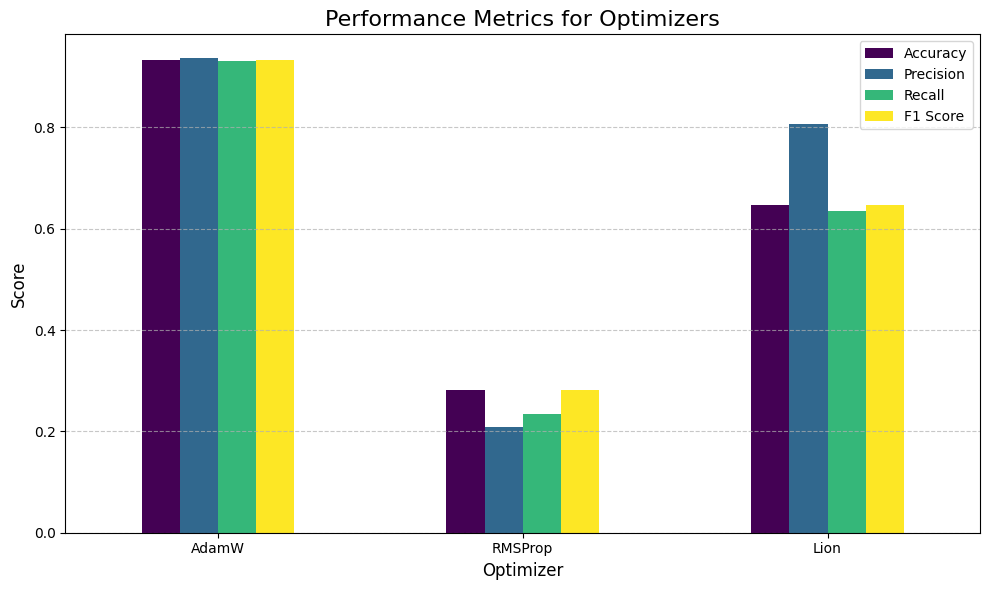

In [96]:
import matplotlib.pyplot as plt
ax = df.set_index("Optimizer").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Performance Metrics for Optimizers", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Optimizer", fontsize=12)
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

## Testing with random dataset

### Put any text here

In [ ]:
text= """'
No air pollution
"""
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
outputs = trainer.model(**inputs)
labels = id2label
index = torch.argmax(outputs.logits)
print(labels[int(index)])

Environment


### Load any data files from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls '/content/gdrive/My Drive/data/2019_cleaned/raw'

In [ ]:
# Load the English NLP model
nlp = spacy.load("en_core_web_sm")
# Path to the folder containing the .txt files
input_folder = "/content/gdrive/My Drive/data/2019_cleaned/raw"
output_folders = {
    "Environmental": "/content/gdrive/My Drive/data/2019_cleaned/Environmental",
    "Governance": "/content/gdrive/My Drive/data/2019_cleaned/Governance",
    "Non-ESG": "/content/gdrive/My Drive/data/2019_cleaned/Non-ESG",
    "Social": "/content/gdrive/My Drive/data/2019_cleaned/Social",
}

# Ensure output folders exist
for folder in output_folders.values():
    os.makedirs(folder, exist_ok=True)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
# Function to classify a sentence
def classify_sentence(sentence):
    labels = id2label
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    outputs = trainer.model(**inputs)
    index = torch.argmax(outputs.logits)  # Get the label index
    return labels[int(index)]

In [ ]:
id2label

{0: 'Social', 1: 'Non-ESG', 2: 'Governance', 3: 'Environment'}

In [ ]:
# Function to process a single file
def process_file(file_path):
  with open(file_path, "r", encoding="utf-8") as file:
    text = file.read()

  # Use spaCy to segment the sentences
  # p = [nlp(pa).text.strip() for pa in text.split("\n")]
  # if len(text) > 120000:
  #
  p = [nlp(pa).text.strip() for pa in text.split("\n\n")]
  e = []
  s = []
  g = []
  n = []

  # Classify each sentence and save it in the corresponding folder
  for i in range(len(p)):
    label = classify_sentence(p[i])
    if label == "Environment":
      e.append(p[i])
    elif label == "Social":
      s.append(p[i])
    elif label == "Governance":
      g.append(p[i])
    else:
      n.append(p[i])

  # Create a new file name
  base_name = os.path.basename(file_path)
  new_file_name = f"{os.path.splitext(base_name)[0]}.txt"
  # Save the sentence in the corresponding folder
  with open(os.path.join(output_folders["Environmental"], new_file_name), "w", encoding="utf-8") as f:
    for l in e:
      f.write(l + "\n")

  with open(os.path.join(output_folders["Social"], new_file_name), "w", encoding="utf-8") as f:
    for l in s:
      f.write(l + "\n")

  with open(os.path.join(output_folders["Governance"], new_file_name), "w", encoding="utf-8") as f:
      for l in g:
        f.write(l + "\n")

  with open(os.path.join(output_folders["Non-ESG"], new_file_name), "w", encoding="utf-8") as f:
      for l in n:
        f.write(l + "\n")

In [ ]:
folder = sorted(os.listdir(input_folder),
                key = lambda x: os.stat(os.path.join(input_folder, x)).st_size)
for i in range(len(folder)):
    if folder[i].endswith(".txt"):
      print(folder[i])
      file_path = os.path.join(input_folder, folder[i])
      process_file(file_path)